In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

!pip install hydroeval
import hydroeval as he

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
  
def create_dataset_X(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

def mean_absolute_percentage_error(y_t, y_p): 
    
    return np.mean(np.abs((y_t - y_p) / y_t)) * 100

##Change the directory to the folder containing long-format csv.
direct = "/content/drive/MyDrive/Final_barley_6"
##Set the name of crop here
crop = "Barley"
##Scroll to bottom and change the directory of output folder

lof = os.listdir(direct)

performance_r2 = []
performance_mape = []
performance_nse = []
car_df = []

for f in lof:
  df = pd.read_csv(direct + "/" + f)

  car_df.append(int(f[7:-4]))
  timeline = []
  for i in range(0, len(df["Year"])):
    timeline.append(i)

  df["Weeks"] = timeline

  df.pop("Year")
  df.pop("Area")

  train_size = int(len(df) * 0.9)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

  full_data = df

  f_columns = ['SumPcpn', 'SumEGDD_C', 'SumHeatD','SumFrostD','AvgSI', 
             'AvgPrcnAWHC','NDVI']

  f_transformer = StandardScaler()
  yld_transformer = StandardScaler()

  f_transformer = f_transformer.fit(train[f_columns].to_numpy())
  yld_transformer = yld_transformer.fit(train[['Yield']])

  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
  train['Yield'] = yld_transformer.transform(train[['Yield']])

  test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
  test['Yield'] = yld_transformer.transform(test[['Yield']])

  time_steps = 19

  # reshape to [samples, time_steps, n_features]

  X_train, y_train = create_dataset(train, train.Yield, time_steps)
  X_test, y_test = create_dataset(test, test.Yield, time_steps)

  print(X_train.shape, y_train.shape)

  !mkdir -p saved_model
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(
      X_train, y_train,
      epochs=30,
      batch_size=32,
      validation_split=0.1,
      shuffle=False,
      verbose = False
  )

  model.save("saved_model" + "/" + f[:-4] + "/" + "model")

  MAX_EPOCHS = 50

  # When training, change Barley_1100 to specific crop

  def compile_and_fit(model, patience=5):
    # Checkpoint callback usage
    checkpoint_path = "saved_model" + "/" + f[:-4] + "/" + "training_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    monitor='val_accuracy',
                                                    verbose=1)
    
    #/# Currently using cp_callback instead of early_stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    # Changed from meansquarederror() to SparseCategoricalCrossentropy()
    # optimizer changed from tf.optimizer.Adam() to 'adam'
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer='adam',
                  metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                        batch_size=32, validation_split=0.1,
                        callbacks=[cp_callback])
    return history

  for i in range(20):
    
    new_model = tf.keras.models.load_model("saved_model" + "/" + f[:-4] + "/" + "model")
    history = compile_and_fit(new_model)

    new_model.save("saved_model" + "/" + f[:-4] + "/" + "model")

  full_data.loc[:, f_columns] = f_transformer.transform(full_data[f_columns].to_numpy())
  #full_data['Yield'] = yld_transformer.transform(full_data[['Yield']])
  X_full_data = create_dataset_X(full_data, time_steps)

  df_pred = new_model.predict(X_full_data)
  #tf.keras.backend.clear_session()
  df_pred_inv = yld_transformer.inverse_transform(df_pred)

  yld_predict = []

  for i in (df_pred_inv):
    yld_predict.append(i[0])

  df = pd.read_csv(direct + "/" + f)
  yld_data = df["Yield"][19:]

  correlation_matrix = np.corrcoef(yld_data.to_numpy(), yld_predict)
  correlation_xy = correlation_matrix[0,1]
  r2 = correlation_xy**2

  #r2 = r2_score(yld_data, yld_predict)
  mape = mean_absolute_percentage_error(yld_data, yld_predict)
  nse = he.evaluator(he.nse, yld_predict, yld_data)

  performance_r2.append(r2)
  performance_mape.append(mape)
  performance_nse.append(nse[0])

  df = df[19:]
  df["Predict"] = yld_predict

  ##Create an output folder named [cropname]_predict, change directory here
  df.to_csv("/content/drive/MyDrive/" + crop + "_predict/" + f, index=False)

performance_df = pd.DataFrame(data={"CARUID": car_df, "R_squared": performance_r2,
                   "MAPE": performance_mape, "MEI": performance_nse})

##Also change directory here
performance_df.to_csv("/content/drive/MyDrive/" + crop + "_predict/" + crop + "_performance.csv", index=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

(562, 19, 9) (562,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 86ms/step - loss: 0.5354 - mean_squared_error: 0.5354 - val_loss: 0.3552 - val_mean_squared_error: 0.3552

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.4565 - mean_squared_error: 0.4565 - val_loss: 0.6544 - val_mean_squared_error: 0.6544

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.4317 - mean_squared_error: 0.4317 - val_loss: 0.2637 - val_mean_squared_error: 0.2637

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.4344 - mean_squared_error: 0.4344 - val_loss: 0.3740 - val_mean_squared_error: 0.3740

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.2339 - val_mean_squared_error: 0.2339

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 34ms/step - loss: 0.1186 - mean_squared_error: 0.1186 - val_loss: 0.1391 - val_mean_squared_error: 0.1391

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 34ms/step - loss: 0.1001 - mean_squared_error: 0.1001 - val_loss: 0.0753 - val_mean_squared_error: 0.0753

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 0.0765 - val_mean_squared_error: 0.0765

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 85ms/step - loss: 0.1141 - mean_squared_error: 0.1141 - val_loss: 0.2835 - val_mean_squared_error: 0.2835

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - val_loss: 0.0696 - val_mean_squared_error: 0.0696

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0763 - mean_squared_error: 0.0763 - val_loss: 0.0544 - val_mean_squared_error: 0.0544

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0780 - mean_squared_error: 0.0780 - val_loss: 0.0974 - val_mean_squared_error: 0.0974

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 98ms/step - loss: 0.0823 - mean_squared_error: 0.0823 - val_loss: 0.1033 - val_mean_squared_error: 0.1033

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 0.0358 - val_mean_squared_error: 0.0358

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 0.1456 - val_mean_squared_error: 0.1456

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.0503 - val_mean_squared_error: 0.0503

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 82ms/step - loss: 0.0751 - mean_squared_error: 0.0751 - val_loss: 0.0459 - val_mean_squared_error: 0.0459

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0627 - val_mean_squared_error: 0.0627

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.0675 - val_mean_squared_error: 0.0675

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0456 - val_mean_squared_error: 0.0456

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 85ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0446 - val_mean_squared_error: 0.0446

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0325 - val_mean_squared_error: 0.0325

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0399 - val_mean_squared_error: 0.0399

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0327 - val_mean_squared_error: 0.0327

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 90ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0554 - val_mean_squared_error: 0.0554

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0314 - val_mean_squared_error: 0.0314

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0268 - val_mean_squared_error: 0.0268

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0374 - val_mean_squared_error: 0.0374

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 87ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0512 - val_mean_squared_error: 0.0512

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0425 - val_mean_squared_error: 0.0425

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0353 - val_mean_squared_error: 0.0353

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0279 - val_mean_squared_error: 0.0279

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 109ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0444 - val_mean_squared_error: 0.0444

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0573 - val_mean_squared_error: 0.0573

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0427 - val_mean_squared_error: 0.0427

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0757 - val_mean_squared_error: 0.0757

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 35ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 86ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0352 - val_mean_squared_error: 0.0352

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0525 - val_mean_squared_error: 0.0525

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0411 - val_mean_squared_error: 0.0411

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0628 - val_mean_squared_error: 0.0628

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 36ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 98ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0515 - val_mean_squared_error: 0.0515

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0423 - val_mean_squared_error: 0.0423

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0480 - val_mean_squared_error: 0.0480

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0402 - val_mean_squared_error: 0.0402

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 4s 86ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0681 - val_mean_squared_error: 0.0681

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0484 - val_mean_squared_error: 0.0484

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0433 - val_mean_squared_error: 0.0433

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0661 - val_mean_squared_error: 0.0661

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 87ms/step - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.0601 - val_mean_squared_error: 0.0601

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0632 - val_mean_squared_error: 0.0632

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0436 - val_mean_squared_error: 0.0436

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0517 - val_mean_squared_error: 0.0517

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 88ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0457 - val_mean_squared_error: 0.0457

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0362 - val_mean_squared_error: 0.0362

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0638 - val_mean_squared_error: 0.0638

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0728 - val_mean_squared_error: 0.0728

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 44ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 85ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0529 - val_mean_squared_error: 0.0529

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0603 - val_mean_squared_error: 0.0603

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0501 - val_mean_squared_error: 0.0501

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0535 - val_mean_squared_error: 0.0535

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 88ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0504 - val_mean_squared_error: 0.0504

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0436 - val_mean_squared_error: 0.0436

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0543 - val_mean_squared_error: 0.0543

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.0583 - val_mean_squared_error: 0.0583

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 99ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0651 - val_mean_squared_error: 0.0651

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0423 - val_mean_squared_error: 0.0423

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0601 - val_mean_squared_error: 0.0601

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0461 - val_mean_squared_error: 0.0461

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 87ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0631 - val_mean_squared_error: 0.0631

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0523 - val_mean_squared_error: 0.0523

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0618 - val_mean_squared_error: 0.0618

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0525 - val_mean_squared_error: 0.0525

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 6s 85ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0702 - val_mean_squared_error: 0.0702

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.0574 - val_mean_squared_error: 0.0574

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0582 - val_mean_squared_error: 0.0582

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0525 - val_mean_squared_error: 0.0525

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


Epoch 1/50
16/16 [==============================] - 5s 95ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0474 - val_mean_squared_error: 0.0474

Epoch 00001: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0580 - val_mean_squared_error: 0.0580

Epoch 00002: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0649 - val_mean_squared_error: 0.0649

Epoch 00003: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0561 - val_mean_squared_error: 0.0561

Epoch 00004: saving model to saved_model/BARLEY_4841/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4841/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(562, 19, 9) (562,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 102ms/step - loss: 0.3382 - mean_squared_error: 0.3382 - val_loss: 0.7761 - val_mean_squared_error: 0.7761

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.3270 - mean_squared_error: 0.3270 - val_loss: 1.1453 - val_mean_squared_error: 1.1453

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 37ms/step - loss: 0.2844 - mean_squared_error: 0.2844 - val_loss: 0.7459 - val_mean_squared_error: 0.7459

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.2695 - mean_squared_error: 0.2695 - val_loss: 0.5598 - val_mean_squared_error: 0.5598

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 106ms/step - loss: 0.0712 - mean_squared_error: 0.0712 - val_loss: 0.1421 - val_mean_squared_error: 0.1421

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.1276 - val_mean_squared_error: 0.1276

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - val_loss: 0.2318 - val_mean_squared_error: 0.2318

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 0.1549 - val_mean_squared_error: 0.1549

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 37ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 86ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0614 - val_mean_squared_error: 0.0614

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 37ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.1172 - val_mean_squared_error: 0.1172

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0653 - val_mean_squared_error: 0.0653

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.2062 - val_mean_squared_error: 0.2062

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 101ms/step - loss: 0.0792 - mean_squared_error: 0.0792 - val_loss: 0.0667 - val_mean_squared_error: 0.0667

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 0.0811 - val_mean_squared_error: 0.0811

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.2345 - val_mean_squared_error: 0.2345

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0563 - val_mean_squared_error: 0.0563

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 86ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0319 - val_mean_squared_error: 0.0319

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.2581 - val_mean_squared_error: 0.2581

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0676 - val_mean_squared_error: 0.0676

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 36ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.1188 - val_mean_squared_error: 0.1188

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 97ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0312 - val_mean_squared_error: 0.0312

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.2240 - val_mean_squared_error: 0.2240

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0622 - val_mean_squared_error: 0.0622

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.1190 - val_mean_squared_error: 0.1190

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 98ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0745 - val_mean_squared_error: 0.0745

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.2157 - val_mean_squared_error: 0.2157

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.0493 - val_mean_squared_error: 0.0493

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.1209 - val_mean_squared_error: 0.1209

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 87ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.3481 - val_mean_squared_error: 0.3481

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.1041 - val_mean_squared_error: 0.1041

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.1388 - val_mean_squared_error: 0.1388

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.1420 - val_mean_squared_error: 0.1420

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 99ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - val_loss: 0.0457 - val_mean_squared_error: 0.0457

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.2586 - val_mean_squared_error: 0.2586

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0968 - val_mean_squared_error: 0.0968

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0969 - val_mean_squared_error: 0.0969

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 98ms/step - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0347 - val_mean_squared_error: 0.0347

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.1006 - val_mean_squared_error: 0.1006

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.1158 - val_mean_squared_error: 0.1158

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0385 - val_mean_squared_error: 0.0385

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 106ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0871 - val_mean_squared_error: 0.0871

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0886 - val_mean_squared_error: 0.0886

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0852 - val_mean_squared_error: 0.0852

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.1068 - val_mean_squared_error: 0.1068

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 111ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.1453 - val_mean_squared_error: 0.1453

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.1176 - val_mean_squared_error: 0.1176

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0344 - val_mean_squared_error: 0.0344

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.1789 - val_mean_squared_error: 0.1789

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 100ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.1470 - val_mean_squared_error: 0.1470

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.1049 - val_mean_squared_error: 0.1049

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.1227 - val_mean_squared_error: 0.1227

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.1054 - val_mean_squared_error: 0.1054

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 88ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0372 - val_mean_squared_error: 0.0372

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0958 - val_mean_squared_error: 0.0958

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0523 - val_mean_squared_error: 0.0523

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 43ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 94ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0586 - val_mean_squared_error: 0.0586

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.1628 - val_mean_squared_error: 0.1628

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.1119 - val_mean_squared_error: 0.1119

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0929 - val_mean_squared_error: 0.0929

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 176ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0753 - val_mean_squared_error: 0.0753

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.2102 - val_mean_squared_error: 0.2102

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0371 - val_mean_squared_error: 0.0371

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0544 - val_mean_squared_error: 0.0544

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 91ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.1218 - val_mean_squared_error: 0.1218

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.1306 - val_mean_squared_error: 0.1306

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.1773 - val_mean_squared_error: 0.1773

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.1348 - val_mean_squared_error: 0.1348

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 6s 89ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0556 - val_mean_squared_error: 0.0556

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0955 - val_mean_squared_error: 0.0955

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.1574 - val_mean_squared_error: 0.1574

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.1068 - val_mean_squared_error: 0.1068

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 39ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 93ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0641 - val_mean_squared_error: 0.0641

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.1240 - val_mean_squared_error: 0.1240

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.1107 - val_mean_squared_error: 0.1107

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.1369 - val_mean_squared_error: 0.1369

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


Epoch 1/50
16/16 [==============================] - 5s 92ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.1061 - val_mean_squared_error: 0.1061

Epoch 00001: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0787 - val_mean_squared_error: 0.0787

Epoch 00002: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0698 - val_mean_squared_error: 0.0698

Epoch 00003: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0598 - val_mean_squared_error: 0.0598

Epoch 00004: saving model to saved_model/BARLEY_4830/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 38ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4830/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(494, 19, 9) (494,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 98ms/step - loss: 0.5905 - mean_squared_error: 0.5905 - val_loss: 0.4372 - val_mean_squared_error: 0.4372

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 40ms/step - loss: 0.5476 - mean_squared_error: 0.5476 - val_loss: 0.5302 - val_mean_squared_error: 0.5302

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 40ms/step - loss: 0.4923 - mean_squared_error: 0.4923 - val_loss: 0.3098 - val_mean_squared_error: 0.3098

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 41ms/step - loss: 0.4092 - mean_squared_error: 0.4092 - val_loss: 0.2396 - val_mean_squared_error: 0.2396

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 97ms/step - loss: 0.1643 - mean_squared_error: 0.1643 - val_loss: 0.0928 - val_mean_squared_error: 0.0928

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 40ms/step - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.0611 - val_mean_squared_error: 0.0611

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 42ms/step - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.0497 - val_mean_squared_error: 0.0497

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 41ms/step - loss: 0.1176 - mean_squared_error: 0.1176 - val_loss: 0.0537 - val_mean_squared_error: 0.0537

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 98ms/step - loss: 0.1071 - mean_squared_error: 0.1071 - val_loss: 0.0598 - val_mean_squared_error: 0.0598

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 39ms/step - loss: 0.0874 - mean_squared_error: 0.0874 - val_loss: 0.0945 - val_mean_squared_error: 0.0945

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0980 - mean_squared_error: 0.0980 - val_loss: 0.0554 - val_mean_squared_error: 0.0554

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - val_loss: 0.0506 - val_mean_squared_error: 0.0506

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 104ms/step - loss: 0.1027 - mean_squared_error: 0.1027 - val_loss: 0.0864 - val_mean_squared_error: 0.0864

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.0517 - val_mean_squared_error: 0.0517

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0654 - val_mean_squared_error: 0.0654

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0635 - mean_squared_error: 0.0635 - val_loss: 0.0710 - val_mean_squared_error: 0.0710

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 42ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 96ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - val_loss: 0.0745 - val_mean_squared_error: 0.0745

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.0561 - val_mean_squared_error: 0.0561

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0561 - val_mean_squared_error: 0.0561

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 39ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0646 - val_mean_squared_error: 0.0646

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 97ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.0776 - val_mean_squared_error: 0.0776

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 39ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0732 - val_mean_squared_error: 0.0732

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0628 - val_mean_squared_error: 0.0628

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0590 - val_mean_squared_error: 0.0590

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 43ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 99ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0697 - val_mean_squared_error: 0.0697

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 39ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0584 - val_mean_squared_error: 0.0584

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0953 - val_mean_squared_error: 0.0953

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 39ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0692 - val_mean_squared_error: 0.0692

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 43ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 100ms/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0805 - val_mean_squared_error: 0.0805

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.0718 - val_mean_squared_error: 0.0718

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.1025 - val_mean_squared_error: 0.1025

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0646 - val_mean_squared_error: 0.0646

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 41ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 100ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0834 - val_mean_squared_error: 0.0834

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0644 - val_mean_squared_error: 0.0644

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0718 - val_mean_squared_error: 0.0718

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0564 - val_mean_squared_error: 0.0564

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 41ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 100ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0592 - val_mean_squared_error: 0.0592

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.1214 - val_mean_squared_error: 0.1214

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0517 - val_mean_squared_error: 0.0517

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0965 - val_mean_squared_error: 0.0965

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 41ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 178ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0898 - val_mean_squared_error: 0.0898

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0888 - val_mean_squared_error: 0.0888

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0601 - val_mean_squared_error: 0.0601

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0744 - val_mean_squared_error: 0.0744

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 100ms/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.1233 - val_mean_squared_error: 0.1233

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0743 - val_mean_squared_error: 0.0743

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0908 - val_mean_squared_error: 0.0908

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.1018 - val_mean_squared_error: 0.1018

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 42ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 100ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0981 - val_mean_squared_error: 0.0981

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 39ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0707 - val_mean_squared_error: 0.0707

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0824 - val_mean_squared_error: 0.0824

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.1462 - val_mean_squared_error: 0.1462

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 39ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 98ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0545 - val_mean_squared_error: 0.0545

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0804 - val_mean_squared_error: 0.0804

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0815 - val_mean_squared_error: 0.0815

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.1423 - val_mean_squared_error: 0.1423

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 98ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.1300 - val_mean_squared_error: 0.1300

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.1007 - val_mean_squared_error: 0.1007

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.1781 - val_mean_squared_error: 0.1781

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0786 - val_mean_squared_error: 0.0786

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 97ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.1246 - val_mean_squared_error: 0.1246

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.1827 - val_mean_squared_error: 0.1827

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0489 - val_mean_squared_error: 0.0489

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0929 - val_mean_squared_error: 0.0929

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 4s 99ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0783 - val_mean_squared_error: 0.0783

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0791 - val_mean_squared_error: 0.0791

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0974 - val_mean_squared_error: 0.0974

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.1092 - val_mean_squared_error: 0.1092

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 95ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0556 - val_mean_squared_error: 0.0556

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.1461 - val_mean_squared_error: 0.1461

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0620 - val_mean_squared_error: 0.0620

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.1426 - val_mean_squared_error: 0.1426

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 94ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.1676 - val_mean_squared_error: 0.1676

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.1443 - val_mean_squared_error: 0.1443

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0422 - val_mean_squared_error: 0.0422

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 40ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.1664 - val_mean_squared_error: 0.1664

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


Epoch 1/50
14/14 [==============================] - 5s 96ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.1968 - val_mean_squared_error: 0.1968

Epoch 00001: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0626 - val_mean_squared_error: 0.0626

Epoch 00002: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.1495 - val_mean_squared_error: 0.1495

Epoch 00003: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.1230 - val_mean_squared_error: 0.1230

Epoch 00004: saving model to saved_model/BARLEY_5901/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5901/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(562, 19, 9) (562,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.4859 - mean_squared_error: 0.4859 - val_loss: 1.3358 - val_mean_squared_error: 1.3358

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.4775 - mean_squared_error: 0.4775 - val_loss: 1.2184 - val_mean_squared_error: 1.2184

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 0.4679 - mean_squared_error: 0.4679 - val_loss: 1.0149 - val_mean_squared_error: 1.0149

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.4484 - mean_squared_error: 0.4484 - val_loss: 0.8445 - val_mean_squared_error: 0.8445

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 123ms/step - loss: 0.1282 - mean_squared_error: 0.1282 - val_loss: 0.1695 - val_mean_squared_error: 0.1695

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 38ms/step - loss: 0.0928 - mean_squared_error: 0.0928 - val_loss: 0.1455 - val_mean_squared_error: 0.1455

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0863 - mean_squared_error: 0.0863 - val_loss: 0.1837 - val_mean_squared_error: 0.1837

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0865 - mean_squared_error: 0.0865 - val_loss: 0.1401 - val_mean_squared_error: 0.1401

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.2671 - val_mean_squared_error: 0.2671

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0844 - mean_squared_error: 0.0844 - val_loss: 0.1631 - val_mean_squared_error: 0.1631

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.1274 - val_mean_squared_error: 0.1274

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.1073 - val_mean_squared_error: 0.1073

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 88ms/step - loss: 0.0759 - mean_squared_error: 0.0759 - val_loss: 0.1737 - val_mean_squared_error: 0.1737

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - val_loss: 0.3094 - val_mean_squared_error: 0.3094

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.1297 - val_mean_squared_error: 0.1297

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0796 - mean_squared_error: 0.0796 - val_loss: 0.1602 - val_mean_squared_error: 0.1602

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 89ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.1550 - val_mean_squared_error: 0.1550

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.1452 - val_mean_squared_error: 0.1452

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0526 - mean_squared_error: 0.0526 - val_loss: 0.1978 - val_mean_squared_error: 0.1978

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - val_loss: 0.1707 - val_mean_squared_error: 0.1707

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 89ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.1366 - val_mean_squared_error: 0.1366

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 39ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 0.2636 - val_mean_squared_error: 0.2636

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.1717 - val_mean_squared_error: 0.1717

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0487 - mean_squared_error: 0.0487 - val_loss: 0.3587 - val_mean_squared_error: 0.3587

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 88ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.2089 - val_mean_squared_error: 0.2089

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.1658 - val_mean_squared_error: 0.1658

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.1628 - val_mean_squared_error: 0.1628

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.2262 - val_mean_squared_error: 0.2262

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 91ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - val_loss: 0.1283 - val_mean_squared_error: 0.1283

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.1841 - val_mean_squared_error: 0.1841

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.2389 - val_mean_squared_error: 0.2389

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0364 - mean_squared_error: 0.0364 - val_loss: 0.1850 - val_mean_squared_error: 0.1850

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 90ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.2380 - val_mean_squared_error: 0.2380

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.2808 - val_mean_squared_error: 0.2808

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.2276 - val_mean_squared_error: 0.2276

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.2598 - val_mean_squared_error: 0.2598

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 88ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.2612 - val_mean_squared_error: 0.2612

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 0.1974 - val_mean_squared_error: 0.1974

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.2705 - val_mean_squared_error: 0.2705

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.2824 - val_mean_squared_error: 0.2824

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 91ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.5102 - val_mean_squared_error: 0.5102

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.2869 - val_mean_squared_error: 0.2869

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.2088 - val_mean_squared_error: 0.2088

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.2698 - val_mean_squared_error: 0.2698

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 91ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.3584 - val_mean_squared_error: 0.3584

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.2386 - val_mean_squared_error: 0.2386

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.4358 - val_mean_squared_error: 0.4358

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.2173 - val_mean_squared_error: 0.2173

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 90ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.3189 - val_mean_squared_error: 0.3189

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.3750 - val_mean_squared_error: 0.3750

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.2745 - val_mean_squared_error: 0.2745

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.3572 - val_mean_squared_error: 0.3572

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 156ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.3462 - val_mean_squared_error: 0.3462

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.3124 - val_mean_squared_error: 0.3124

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.3213 - val_mean_squared_error: 0.3213

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.3124 - val_mean_squared_error: 0.3124

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 43ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 89ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.3563 - val_mean_squared_error: 0.3563

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.2545 - val_mean_squared_error: 0.2545

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.3173 - val_mean_squared_error: 0.3173

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.3333 - val_mean_squared_error: 0.3333

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 5s 90ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.2933 - val_mean_squared_error: 0.2933

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.3784 - val_mean_squared_error: 0.3784

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.2612 - val_mean_squared_error: 0.2612

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 40ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.2973 - val_mean_squared_error: 0.2973

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 40ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 91ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.3866 - val_mean_squared_error: 0.3866

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.3346 - val_mean_squared_error: 0.3346

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.3652 - val_mean_squared_error: 0.3652

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.3389 - val_mean_squared_error: 0.3389

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 92ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.3282 - val_mean_squared_error: 0.3282

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.3484 - val_mean_squared_error: 0.3484

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - val_loss: 0.3911 - val_mean_squared_error: 0.3911

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.3183 - val_mean_squared_error: 0.3183

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 43ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 94ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.5326 - val_mean_squared_error: 0.5326

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.4399 - val_mean_squared_error: 0.4399

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 44ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.2584 - val_mean_squared_error: 0.2584

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.4814 - val_mean_squared_error: 0.4814

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 43ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


Epoch 1/50
16/16 [==============================] - 4s 92ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.2435 - val_mean_squared_error: 0.2435

Epoch 00001: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.5453 - val_mean_squared_error: 0.5453

Epoch 00002: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 42ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.2862 - val_mean_squared_error: 0.2862

Epoch 00003: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 41ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.3957 - val_mean_squared_error: 0.3957

Epoch 00004: saving model to saved_model/BARLEY_4870/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 42ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4870/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(494, 19, 9) (494,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 97ms/step - loss: 0.4476 - mean_squared_error: 0.4476 - val_loss: 0.5779 - val_mean_squared_error: 0.5779

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 42ms/step - loss: 0.4382 - mean_squared_error: 0.4382 - val_loss: 0.5310 - val_mean_squared_error: 0.5310

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 42ms/step - loss: 0.3453 - mean_squared_error: 0.3453 - val_loss: 0.6887 - val_mean_squared_error: 0.6887

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 43ms/step - loss: 0.3286 - mean_squared_error: 0.3286 - val_loss: 0.6531 - val_mean_squared_error: 0.6531

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 41ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 103ms/step - loss: 0.1719 - mean_squared_error: 0.1719 - val_loss: 0.0812 - val_mean_squared_error: 0.0812

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 44ms/step - loss: 0.1119 - mean_squared_error: 0.1119 - val_loss: 0.0442 - val_mean_squared_error: 0.0442

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 42ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - val_loss: 0.0148 - val_mean_squared_error: 0.0148

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 45ms/step - loss: 0.1066 - mean_squared_error: 0.1066 - val_loss: 0.0275 - val_mean_squared_error: 0.0275

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 43ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 100ms/step - loss: 0.0993 - mean_squared_error: 0.0993 - val_loss: 0.1119 - val_mean_squared_error: 0.1119

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0805 - mean_squared_error: 0.0805 - val_loss: 0.0192 - val_mean_squared_error: 0.0192

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0730 - mean_squared_error: 0.0730 - val_loss: 0.0170 - val_mean_squared_error: 0.0170

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0227 - val_mean_squared_error: 0.0227

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 45ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 100ms/step - loss: 0.0778 - mean_squared_error: 0.0778 - val_loss: 0.0448 - val_mean_squared_error: 0.0448

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.2091 - val_mean_squared_error: 0.2091

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0678 - mean_squared_error: 0.0678 - val_loss: 0.0622 - val_mean_squared_error: 0.0622

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - val_loss: 0.1153 - val_mean_squared_error: 0.1153

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 43ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 175ms/step - loss: 0.0637 - mean_squared_error: 0.0637 - val_loss: 0.1377 - val_mean_squared_error: 0.1377

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.1829 - val_mean_squared_error: 0.1829

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.2179 - val_mean_squared_error: 0.2179

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 48ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0879 - val_mean_squared_error: 0.0879

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 43ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 97ms/step - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.4040 - val_mean_squared_error: 0.4040

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 46ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.1260 - val_mean_squared_error: 0.1260

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.2970 - val_mean_squared_error: 0.2970

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 47ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.1448 - val_mean_squared_error: 0.1448

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 44ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 100ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0916 - val_mean_squared_error: 0.0916

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - val_loss: 0.4306 - val_mean_squared_error: 0.4306

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 46ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.1084 - val_mean_squared_error: 0.1084

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.4143 - val_mean_squared_error: 0.4143

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 45ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 101ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.1744 - val_mean_squared_error: 0.1744

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 41ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.1761 - val_mean_squared_error: 0.1761

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.2192 - val_mean_squared_error: 0.2192

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.2191 - val_mean_squared_error: 0.2191

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 42ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 103ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.1697 - val_mean_squared_error: 0.1697

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 46ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.1936 - val_mean_squared_error: 0.1936

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.3424 - val_mean_squared_error: 0.3424

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.3152 - val_mean_squared_error: 0.3152

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 44ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 100ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.4664 - val_mean_squared_error: 0.4664

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 46ms/step - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 0.3196 - val_mean_squared_error: 0.3196

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 42ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.3020 - val_mean_squared_error: 0.3020

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.3049 - val_mean_squared_error: 0.3049

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 43ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 100ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.2877 - val_mean_squared_error: 0.2877

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.1887 - val_mean_squared_error: 0.1887

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.2935 - val_mean_squared_error: 0.2935

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 47ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.2426 - val_mean_squared_error: 0.2426

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 52ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 101ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.4199 - val_mean_squared_error: 0.4199

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.2852 - val_mean_squared_error: 0.2852

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 48ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - val_loss: 0.2653 - val_mean_squared_error: 0.2653

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 46ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.3474 - val_mean_squared_error: 0.3474

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 44ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 6s 200ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.2002 - val_mean_squared_error: 0.2002

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 51ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.2260 - val_mean_squared_error: 0.2260

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 53ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.5170 - val_mean_squared_error: 0.5170

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 49ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.3654 - val_mean_squared_error: 0.3654

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 46ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 104ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.3013 - val_mean_squared_error: 0.3013

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.3335 - val_mean_squared_error: 0.3335

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 48ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.4694 - val_mean_squared_error: 0.4694

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 50ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.1727 - val_mean_squared_error: 0.1727

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 52ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 104ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.3393 - val_mean_squared_error: 0.3393

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.2836 - val_mean_squared_error: 0.2836

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 46ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.2263 - val_mean_squared_error: 0.2263

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 47ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.1843 - val_mean_squared_error: 0.1843

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 47ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 107ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.2662 - val_mean_squared_error: 0.2662

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.3526 - val_mean_squared_error: 0.3526

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 43ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.2992 - val_mean_squared_error: 0.2992

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.2592 - val_mean_squared_error: 0.2592

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 50ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 102ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.2969 - val_mean_squared_error: 0.2969

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 47ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.4828 - val_mean_squared_error: 0.4828

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 48ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.3780 - val_mean_squared_error: 0.3780

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.2834 - val_mean_squared_error: 0.2834

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 47ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 4s 102ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.3634 - val_mean_squared_error: 0.3634

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 50ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.1940 - val_mean_squared_error: 0.1940

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 45ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.4476 - val_mean_squared_error: 0.4476

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 50ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.2490 - val_mean_squared_error: 0.2490

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 47ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 105ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.2004 - val_mean_squared_error: 0.2004

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 48ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.3328 - val_mean_squared_error: 0.3328

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 44ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.2835 - val_mean_squared_error: 0.2835

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 47ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.3716 - val_mean_squared_error: 0.3716

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 49ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


Epoch 1/50
14/14 [==============================] - 5s 103ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.2394 - val_mean_squared_error: 0.2394

Epoch 00001: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 2/50
14/14 [==============================] - 1s 47ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.2117 - val_mean_squared_error: 0.2117

Epoch 00002: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 3/50
14/14 [==============================] - 1s 51ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.2627 - val_mean_squared_error: 0.2627

Epoch 00003: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 4/50
14/14 [==============================] - 1s 48ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.1760 - val_mean_squared_error: 0.1760

Epoch 00004: saving model to saved_model/BARLEY_5908/training_1/cp.ckpt
Epoch 5/50
14/14 [==============================] - 1s 52ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_5908/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(562, 19, 9) (562,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 5s 104ms/step - loss: 0.5126 - mean_squared_error: 0.5126 - val_loss: 0.6247 - val_mean_squared_error: 0.6247

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 53ms/step - loss: 0.5000 - mean_squared_error: 0.5000 - val_loss: 0.7413 - val_mean_squared_error: 0.7413

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 52ms/step - loss: 0.4574 - mean_squared_error: 0.4574 - val_loss: 0.6168 - val_mean_squared_error: 0.6168

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 51ms/step - loss: 0.4584 - mean_squared_error: 0.4584 - val_loss: 0.4807 - val_mean_squared_error: 0.4807

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 48ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 5s 99ms/step - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1030 - val_mean_squared_error: 0.1030

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 43ms/step - loss: 0.0978 - mean_squared_error: 0.0978 - val_loss: 0.0921 - val_mean_squared_error: 0.0921

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 46ms/step - loss: 0.1146 - mean_squared_error: 0.1146 - val_loss: 0.0895 - val_mean_squared_error: 0.0895

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0991 - mean_squared_error: 0.0991 - val_loss: 0.0658 - val_mean_squared_error: 0.0658

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 98ms/step - loss: 0.1101 - mean_squared_error: 0.1101 - val_loss: 0.3028 - val_mean_squared_error: 0.3028

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0686 - val_mean_squared_error: 0.0686

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0812 - mean_squared_error: 0.0812 - val_loss: 0.0919 - val_mean_squared_error: 0.0919

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0817 - mean_squared_error: 0.0817 - val_loss: 0.0624 - val_mean_squared_error: 0.0624

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 49ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 98ms/step - loss: 0.0941 - mean_squared_error: 0.0941 - val_loss: 0.0642 - val_mean_squared_error: 0.0642

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.1124 - val_mean_squared_error: 0.1124

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0686 - val_mean_squared_error: 0.0686

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0883 - val_mean_squared_error: 0.0883

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 4s 94ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.0879 - val_mean_squared_error: 0.0879

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0628 - mean_squared_error: 0.0628 - val_loss: 0.0570 - val_mean_squared_error: 0.0570

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - val_loss: 0.1133 - val_mean_squared_error: 0.1133

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0.1997 - val_mean_squared_error: 0.1997

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 49ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 4s 95ms/step - loss: 0.0603 - mean_squared_error: 0.0603 - val_loss: 0.0658 - val_mean_squared_error: 0.0658

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0500 - mean_squared_error: 0.0500 - val_loss: 0.0645 - val_mean_squared_error: 0.0645

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 0.0597 - val_mean_squared_error: 0.0597

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.0734 - val_mean_squared_error: 0.0734

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 50ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 5s 96ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.2002 - val_mean_squared_error: 0.2002

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0708 - val_mean_squared_error: 0.0708

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.0718 - val_mean_squared_error: 0.0718

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0752 - val_mean_squared_error: 0.0752

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 46ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 4s 94ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 0.0613 - val_mean_squared_error: 0.0613

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0383 - mean_squared_error: 0.0383 - val_loss: 0.1051 - val_mean_squared_error: 0.1051

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0777 - val_mean_squared_error: 0.0777

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.1033 - val_mean_squared_error: 0.1033

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 50ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 97ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0802 - val_mean_squared_error: 0.0802

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0722 - val_mean_squared_error: 0.0722

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0862 - val_mean_squared_error: 0.0862

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0961 - val_mean_squared_error: 0.0961

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 50ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 101ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0758 - val_mean_squared_error: 0.0758

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.1140 - val_mean_squared_error: 0.1140

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.0830 - val_mean_squared_error: 0.0830

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0814 - val_mean_squared_error: 0.0814

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 49ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 100ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0775 - val_mean_squared_error: 0.0775

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0720 - val_mean_squared_error: 0.0720

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0695 - val_mean_squared_error: 0.0695

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0705 - val_mean_squared_error: 0.0705

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 52ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 99ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0801 - val_mean_squared_error: 0.0801

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.1061 - val_mean_squared_error: 0.1061

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0862 - val_mean_squared_error: 0.0862

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0753 - val_mean_squared_error: 0.0753

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 53ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 98ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0841 - val_mean_squared_error: 0.0841

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.1037 - val_mean_squared_error: 0.1037

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 45ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0711 - val_mean_squared_error: 0.0711

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0796 - val_mean_squared_error: 0.0796

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 45ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 99ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0741 - val_mean_squared_error: 0.0741

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0781 - val_mean_squared_error: 0.0781

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0889 - val_mean_squared_error: 0.0889

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0834 - val_mean_squared_error: 0.0834

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 50ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 99ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.1024 - val_mean_squared_error: 0.1024

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0686 - val_mean_squared_error: 0.0686

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0804 - val_mean_squared_error: 0.0804

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.0837 - val_mean_squared_error: 0.0837

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 50ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 170ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0989 - val_mean_squared_error: 0.0989

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0784 - val_mean_squared_error: 0.0784

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.1024 - val_mean_squared_error: 0.1024

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.1096 - val_mean_squared_error: 0.1096

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 54ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 5s 98ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.1079 - val_mean_squared_error: 0.1079

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.1008 - val_mean_squared_error: 0.1008

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0907 - val_mean_squared_error: 0.0907

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0791 - val_mean_squared_error: 0.0791

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 50ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 6s 106ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - val_loss: 0.0883 - val_mean_squared_error: 0.0883

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.1137 - val_mean_squared_error: 0.1137

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.1133 - val_mean_squared_error: 0.1133

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0814 - val_mean_squared_error: 0.0814

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 48ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 5s 101ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0969 - val_mean_squared_error: 0.0969

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.1022 - val_mean_squared_error: 0.1022

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0841 - val_mean_squared_error: 0.0841

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0750 - val_mean_squared_error: 0.0750

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 56ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


Epoch 1/50
16/16 [==============================] - 5s 98ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0829 - val_mean_squared_error: 0.0829

Epoch 00001: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0852 - val_mean_squared_error: 0.0852

Epoch 00002: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0913 - val_mean_squared_error: 0.0913

Epoch 00003: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0872 - val_mean_squared_error: 0.0872

Epoch 00004: saving model to saved_model/BARLEY_4840/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 54ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4840/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(562, 19, 9) (562,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 6s 98ms/step - loss: 0.2851 - mean_squared_error: 0.2851 - val_loss: 0.3153 - val_mean_squared_error: 0.3153

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 49ms/step - loss: 0.2236 - mean_squared_error: 0.2236 - val_loss: 0.2528 - val_mean_squared_error: 0.2528

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 51ms/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.2843 - val_mean_squared_error: 0.2843

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.1971 - mean_squared_error: 0.1971 - val_loss: 0.2528 - val_mean_squared_error: 0.2528

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 51ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 97ms/step - loss: 0.1537 - mean_squared_error: 0.1537 - val_loss: 0.1328 - val_mean_squared_error: 0.1328

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 0.2505 - val_mean_squared_error: 0.2505

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0867 - mean_squared_error: 0.0867 - val_loss: 0.1149 - val_mean_squared_error: 0.1149

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0842 - mean_squared_error: 0.0842 - val_loss: 0.1374 - val_mean_squared_error: 0.1374

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 51ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 98ms/step - loss: 0.0972 - mean_squared_error: 0.0972 - val_loss: 0.1264 - val_mean_squared_error: 0.1264

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - val_loss: 0.1354 - val_mean_squared_error: 0.1354

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - val_loss: 0.1253 - val_mean_squared_error: 0.1253

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 49ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 0.1267 - val_mean_squared_error: 0.1267

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 48ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 6s 97ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - val_loss: 0.1769 - val_mean_squared_error: 0.1769

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 0.1004 - val_mean_squared_error: 0.1004

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0974 - val_mean_squared_error: 0.0974

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0934 - val_mean_squared_error: 0.0934

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 47ms/step

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 6s 107ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - val_loss: 0.0988 - val_mean_squared_error: 0.0988

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.1543 - val_mean_squared_error: 0.1543

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.1052 - val_mean_squared_error: 0.1052

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.1157 - val_mean_squared_error: 0.1157

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 54ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 6s 105ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.1419 - val_mean_squared_error: 0.1419

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 50ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.1791 - val_mean_squared_error: 0.1791

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.1312 - val_mean_squared_error: 0.1312

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.1087 - val_mean_squared_error: 0.1087

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 54ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 6s 105ms/step - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.2296 - val_mean_squared_error: 0.2296

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 0.1407 - val_mean_squared_error: 0.1407

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0816 - val_mean_squared_error: 0.0816

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 63ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0898 - val_mean_squared_error: 0.0898

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 59ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 6s 107ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 0.1002 - val_mean_squared_error: 0.1002

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.1111 - val_mean_squared_error: 0.1111

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.1719 - val_mean_squared_error: 0.1719

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.1113 - val_mean_squared_error: 0.1113

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 58ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 6s 170ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.1725 - val_mean_squared_error: 0.1725

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0940 - val_mean_squared_error: 0.0940

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 56ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.1013 - val_mean_squared_error: 0.1013

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.1142 - val_mean_squared_error: 0.1142

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 55ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 107ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.1244 - val_mean_squared_error: 0.1244

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.1519 - val_mean_squared_error: 0.1519

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0738 - val_mean_squared_error: 0.0738

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 56ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.0806 - val_mean_squared_error: 0.0806

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 58ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 104ms/step - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0939 - val_mean_squared_error: 0.0939

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0905 - val_mean_squared_error: 0.0905

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0757 - val_mean_squared_error: 0.0757

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0876 - val_mean_squared_error: 0.0876

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 57ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 105ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.1435 - val_mean_squared_error: 0.1435

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.1666 - val_mean_squared_error: 0.1666

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - val_loss: 0.0923 - val_mean_squared_error: 0.0923

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.1187 - val_mean_squared_error: 0.1187

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 59ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 105ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.1023 - val_mean_squared_error: 0.1023

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0980 - val_mean_squared_error: 0.0980

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0892 - val_mean_squared_error: 0.0892

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 56ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0861 - val_mean_squared_error: 0.0861

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 60ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 106ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.1259 - val_mean_squared_error: 0.1259

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.1024 - val_mean_squared_error: 0.1024

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0780 - val_mean_squared_error: 0.0780

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0806 - val_mean_squared_error: 0.0806

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 57ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 104ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.1695 - val_mean_squared_error: 0.1695

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0827 - val_mean_squared_error: 0.0827

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0956 - val_mean_squared_error: 0.0956

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0935 - val_mean_squared_error: 0.0935

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 56ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 108ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0719 - val_mean_squared_error: 0.0719

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.1097 - val_mean_squared_error: 0.1097

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.1207 - val_mean_squared_error: 0.1207

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.1413 - val_mean_squared_error: 0.1413

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 60ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 6s 106ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.1302 - val_mean_squared_error: 0.1302

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0965 - val_mean_squared_error: 0.0965

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 0.1074 - val_mean_squared_error: 0.1074

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0970 - val_mean_squared_error: 0.0970

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 60ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 4s 103ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0602 - val_mean_squared_error: 0.0602

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0867 - val_mean_squared_error: 0.0867

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0787 - val_mean_squared_error: 0.0787

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.1413 - val_mean_squared_error: 0.1413

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 59ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 107ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0956 - val_mean_squared_error: 0.0956

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0823 - val_mean_squared_error: 0.0823

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.1177 - val_mean_squared_error: 0.1177

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 63ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.1014 - val_mean_squared_error: 0.1014

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 60ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


Epoch 1/50
16/16 [==============================] - 5s 100ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0906 - val_mean_squared_error: 0.0906

Epoch 00001: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 52ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0817 - val_mean_squared_error: 0.0817

Epoch 00002: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.1201 - val_mean_squared_error: 0.1201

Epoch 00003: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - val_loss: 0.1135 - val_mean_squared_error: 0.1135

Epoch 00004: saving model to saved_model/BARLEY_4860/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 60ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4860/model/assets
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

(562, 19, 9) (562,)


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 107ms/step - loss: 0.5267 - mean_squared_error: 0.5267 - val_loss: 0.6070 - val_mean_squared_error: 0.6070

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 59ms/step - loss: 0.5013 - mean_squared_error: 0.5013 - val_loss: 0.9201 - val_mean_squared_error: 0.9201

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 58ms/step - loss: 0.4753 - mean_squared_error: 0.4753 - val_loss: 0.5618 - val_mean_squared_error: 0.5618

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 63ms/step - loss: 0.4070 - mean_squared_error: 0.4070 - val_loss: 0.4837 - val_mean_squared_error: 0.4837

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 60ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 106ms/step - loss: 0.1454 - mean_squared_error: 0.1454 - val_loss: 0.1773 - val_mean_squared_error: 0.1773

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 60ms/step - loss: 0.1250 - mean_squared_error: 0.1250 - val_loss: 0.1224 - val_mean_squared_error: 0.1224

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 58ms/step - loss: 0.1167 - mean_squared_error: 0.1167 - val_loss: 0.1338 - val_mean_squared_error: 0.1338

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 58ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1102 - val_mean_squared_error: 0.1102

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 57ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 105ms/step - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.0711 - val_mean_squared_error: 0.0711

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0828 - mean_squared_error: 0.0828 - val_loss: 0.1004 - val_mean_squared_error: 0.1004

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.0931 - val_mean_squared_error: 0.0931

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0757 - mean_squared_error: 0.0757 - val_loss: 0.0665 - val_mean_squared_error: 0.0665

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 57ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 6s 113ms/step - loss: 0.0916 - mean_squared_error: 0.0916 - val_loss: 0.1392 - val_mean_squared_error: 0.1392

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0839 - mean_squared_error: 0.0839 - val_loss: 0.0456 - val_mean_squared_error: 0.0456

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0964 - mean_squared_error: 0.0964 - val_loss: 0.2691 - val_mean_squared_error: 0.2691

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 56ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.1970 - val_mean_squared_error: 0.1970

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 58ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 6s 176ms/step - loss: 0.0768 - mean_squared_error: 0.0768 - val_loss: 0.0752 - val_mean_squared_error: 0.0752

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 0.1169 - val_mean_squared_error: 0.1169

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0673 - val_mean_squared_error: 0.0673

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 0.1010 - val_mean_squared_error: 0.1010

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 58ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 110ms/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0459 - val_mean_squared_error: 0.0459

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.1198 - val_mean_squared_error: 0.1198

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 54ms/step - loss: 0.0528 - mean_squared_error: 0.0528 - val_loss: 0.0717 - val_mean_squared_error: 0.0717

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0837 - val_mean_squared_error: 0.0837

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 55ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 6s 106ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 0.0665 - val_mean_squared_error: 0.0665

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0540 - mean_squared_error: 0.0540 - val_loss: 0.0296 - val_mean_squared_error: 0.0296

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.1627 - val_mean_squared_error: 0.1627

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 56ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0636 - val_mean_squared_error: 0.0636

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 59ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 108ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0576 - val_mean_squared_error: 0.0576

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.1546 - val_mean_squared_error: 0.1546

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 63ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0923 - val_mean_squared_error: 0.0923

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0787 - val_mean_squared_error: 0.0787

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 59ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 106ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.1365 - val_mean_squared_error: 0.1365

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0267 - val_mean_squared_error: 0.0267

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0608 - val_mean_squared_error: 0.0608

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 57ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 104ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.1212 - val_mean_squared_error: 0.1212

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - val_loss: 0.1041 - val_mean_squared_error: 0.1041

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 64ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.1393 - val_mean_squared_error: 0.1393

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0539 - val_mean_squared_error: 0.0539

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 60ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 107ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0745 - val_mean_squared_error: 0.0745

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0571 - val_mean_squared_error: 0.0571

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0815 - val_mean_squared_error: 0.0815

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 63ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - val_loss: 0.0805 - val_mean_squared_error: 0.0805

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 59ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 107ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0756 - val_mean_squared_error: 0.0756

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0340 - mean_squared_error: 0.0340 - val_loss: 0.0739 - val_mean_squared_error: 0.0739

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.0397 - val_mean_squared_error: 0.0397

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 57ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0653 - val_mean_squared_error: 0.0653

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 58ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 109ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0402 - val_mean_squared_error: 0.0402

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.1154 - val_mean_squared_error: 0.1154

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.1102 - val_mean_squared_error: 0.1102

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 65ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - val_loss: 0.0894 - val_mean_squared_error: 0.0894

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 62ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 6s 111ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0940 - val_mean_squared_error: 0.0940

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 56ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.1710 - val_mean_squared_error: 0.1710

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 60ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.1434 - val_mean_squared_error: 0.1434

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.1424 - val_mean_squared_error: 0.1424

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 61ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 103ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.1267 - val_mean_squared_error: 0.1267

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.1122 - val_mean_squared_error: 0.1122

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 62ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.1258 - val_mean_squared_error: 0.1258

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 59ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.1932 - val_mean_squared_error: 0.1932

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 62ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 110ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0700 - val_mean_squared_error: 0.0700

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0766 - val_mean_squared_error: 0.0766

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0886 - val_mean_squared_error: 0.0886

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - val_loss: 0.1245 - val_mean_squared_error: 0.1245

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 64ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 108ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.2239 - val_mean_squared_error: 0.2239

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - val_loss: 0.1687 - val_mean_squared_error: 0.1687

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 66ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.1717 - val_mean_squared_error: 0.1717

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 62ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0744 - val_mean_squared_error: 0.0744

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 61ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 106ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0738 - val_mean_squared_error: 0.0738

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0581 - val_mean_squared_error: 0.0581

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0895 - val_mean_squared_error: 0.0895

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 62ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0766 - val_mean_squared_error: 0.0766

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 59ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 5s 110ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0357 - val_mean_squared_error: 0.0357

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.1098 - val_mean_squared_error: 0.1098

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 61ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0466 - val_mean_squared_error: 0.0466

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 62ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0778 - val_mean_squared_error: 0.0778

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 60ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


Epoch 1/50
16/16 [==============================] - 6s 121ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0685 - val_mean_squared_error: 0.0685

Epoch 00001: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.1210 - val_mean_squared_error: 0.1210

Epoch 00002: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 3/50
16/16 [==============================] - 1s 62ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0542 - val_mean_squared_error: 0.0542

Epoch 00003: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 4/50
16/16 [==============================] - 1s 58ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.1011 - val_mean_squared_error: 0.1011

Epoch 00004: saving model to saved_model/BARLEY_4850/training_1/cp.ckpt
Epoch 5/50
16/16 [==============================] - 1s 54ms/ste

INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


INFO:tensorflow:Assets written to: saved_model/BARLEY_4850/model/assets


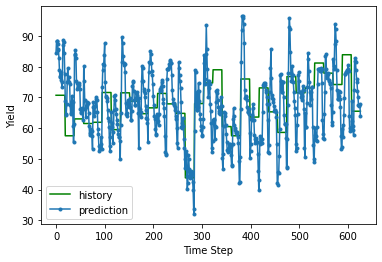

In [6]:
pred = np.asarray(yld_predict, dtype=np.float32)

plt.plot(np.arange(0, len(yld_data.to_numpy())), yld_data.to_numpy().flatten(), 'g', label="history")
plt.plot(np.arange(0, len(pred)), pred.flatten(), marker='.', label="prediction")
plt.ylabel('Yield')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [7]:
performance_df = pd.DataFrame(data={"CARUID": car_df, "R_squared": performance_r2,
                   "MAPE": performance_mape, "MEI": performance_nse})

performance_df.to_csv("/content/drive/MyDrive/" + crop + "_predict/" + crop + "_performance.csv", index=False)

In [8]:
correlation_matrix = np.corrcoef(yld_data.to_numpy(), yld_predict)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
he.evaluator(he.nse, yld_predict, yld_data.to_numpy())
r_squared

0.18510118190815958